In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_52_305.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_0_5445.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_33_237.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_5_8221.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_67_8050.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_56_4689.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_48_1583.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_12_2082.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_39_8004.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/FU-nail-fungus/_19_7696.jpg
/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_se

In [2]:
# ========== STEP 1: Imports & Setup ==========
import os, sys, random, shutil, numpy as np, pandas as pd
from pathlib import Path

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

2025-09-07 17:51:02.754304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757267463.078054      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757267463.172873      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Paths (EDIT THESE if your paths differ)
BASE_DIR  = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet"  # <- change if needed
TRAIN_DIR = f"{BASE_DIR}/train_set"
TEST_DIR  = f"{BASE_DIR}/test_set"

In [7]:
# Quick check
print("TensorFlow:", tf.__version__)
print("Train dir exists?", os.path.isdir(TRAIN_DIR))
print("Test dir exists? ", os.path.isdir(TEST_DIR))


TensorFlow: 2.18.0
Train dir exists? True
Test dir exists?  True


In [8]:
# Reproducibility (optional)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [9]:
IMG_SIZE   = (224, 224)   # standardize image size
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

In [10]:
# ========== STEP 2: Class list & counts ==========

def count_images_per_class(root):
    root = Path(root)
    rows = []
    for cls_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        n = len(list(cls_dir.glob("*.jpg"))) + len(list(cls_dir.glob("*.jpeg"))) + len(list(cls_dir.glob("*.png")))
        rows.append({"split": root.name, "class": cls_dir.name, "count": n})
    return pd.DataFrame(rows)

In [11]:
train_counts = count_images_per_class(TRAIN_DIR)
test_counts  = count_images_per_class(TEST_DIR)

In [12]:
print('train_counts',train_counts)



train_counts        split                       class  count
0  train_set              BA- cellulitis    135
1  train_set                 BA-impetigo     80
2  train_set             FU-athlete-foot    124
3  train_set              FU-nail-fungus    129
4  train_set                 FU-ringworm     90
5  train_set  PA-cutaneous-larva-migrans    100
6  train_set               VI-chickenpox    136
7  train_set                 VI-shingles    130


In [13]:

print('test_counts', test_counts)

test_counts       split                       class  count
0  test_set              BA- cellulitis     33
1  test_set                 BA-impetigo     20
2  test_set             FU-athlete-foot     32
3  test_set              FU-nail-fungus     33
4  test_set                 FU-ringworm     23
5  test_set  PA-cutaneous-larva-migrans     25
6  test_set               VI-chickenpox     34
7  test_set                 VI-shingles     33


In [14]:
display(train_counts)
display(test_counts)


,split,class,count
0,train_set,BA- cellulitis,135
1,train_set,BA-impetigo,80
2,train_set,FU-athlete-foot,124
3,train_set,FU-nail-fungus,129
4,train_set,FU-ringworm,90
5,train_set,PA-cutaneous-larva-migrans,100
6,train_set,VI-chickenpox,136
7,train_set,VI-shingles,130


,split,class,count
0,test_set,BA- cellulitis,33
1,test_set,BA-impetigo,20
2,test_set,FU-athlete-foot,32
3,test_set,FU-nail-fungus,33
4,test_set,FU-ringworm,23
5,test_set,PA-cutaneous-larva-migrans,25
6,test_set,VI-chickenpox,34
7,test_set,VI-shingles,33


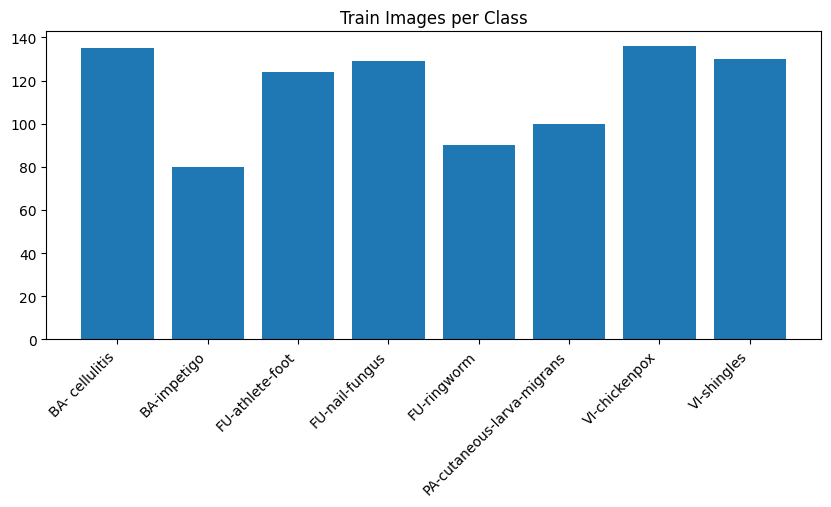

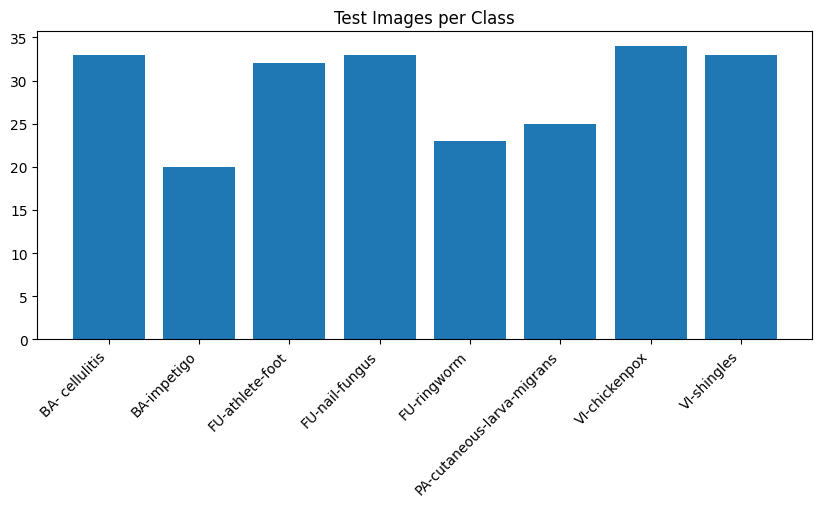

In [15]:
# (Optional) bar plot
plt.figure(figsize=(10,4))
plt.title("Train Images per Class")
plt.bar(train_counts["class"], train_counts["count"])
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(10,4))
plt.title("Test Images per Class")
plt.bar(test_counts["class"], test_counts["count"])
plt.xticks(rotation=45, ha="right")
plt.show()

In [16]:
# ========== STEP 3: Build tf.data datasets ==========
# We'll create a small validation split from TRAIN (e.g., 10%) for tuning/early stopping.

VAL_SPLIT = 0.10

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"  # 8-class softmax
)


Found 924 files belonging to 8 classes.
Using 832 files for training.


I0000 00:00:1757267509.921620      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757267509.922282      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [18]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)



Found 924 files belonging to 8 classes.
Using 92 files for validation.


In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,            # keep order for evaluation
    label_mode="categorical"
)



Found 233 files belonging to 8 classes.


In [20]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)



Classes: ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']


In [21]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

# Paths
ORIG_DIR = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set"   # original training images
AUG_DIR  = "/kaggle/working/augmented_train"            # new folder to save augmented data
IMG_SIZE = (224,224)

# Create augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Loop through each class folder
for cls in os.listdir(ORIG_DIR):
    src_folder = os.path.join(ORIG_DIR, cls)
    dst_folder = os.path.join(AUG_DIR, cls)
    os.makedirs(dst_folder, exist_ok=True)

    for img_name in os.listdir(src_folder):
        img_path = os.path.join(src_folder, img_name)
        img = cv2.imread(img_path)
        if img is None: 
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        x = np.expand_dims(img, axis=0)

        # Generate 5 augmented copies per original
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=dst_folder,
                                  save_prefix="aug", save_format="jpg"):
            i += 1
            if i > 5:   # <-- change this number to create more/less copies
                break

print("Augmentation completed! New images saved in:", AUG_DIR)


Augmentation completed! New images saved in: /kaggle/working/augmented_train


In [22]:
def count_images(root):
    rows = []
    for cls_dir in Path(root).iterdir():
        if cls_dir.is_dir():
            n = len(list(cls_dir.glob("*.jpg"))) + len(list(cls_dir.glob("*.png")))
            rows.append((cls_dir.name, n))
    return rows

counts = count_images(AUG_DIR)
print("Images per class after augmentation:")
for cls, n in counts:
    print(f"{cls}: {n} images")

total = sum([n for _, n in counts])
print("\nTOTAL images after augmentation:", total)


Images per class after augmentation:
BA-impetigo: 466 images
VI-shingles: 753 images
PA-cutaneous-larva-migrans: 581 images
FU-ringworm: 526 images
VI-chickenpox: 775 images
FU-athlete-foot: 697 images
BA- cellulitis: 775 images
FU-nail-fungus: 743 images

TOTAL images after augmentation: 5316


In [24]:
import os, shutil
from pathlib import Path

ORIG_DIR  = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set"   # original train
AUG_DIR   = "/kaggle/working/augmented_train"            # from previous step
FINAL_TRAIN_DIR = "/kaggle/working/final_train"          # merged output
TEST_DIR  = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set"    # unchanged

# fresh final folder
if os.path.exists(FINAL_TRAIN_DIR):
    shutil.rmtree(FINAL_TRAIN_DIR)
os.makedirs(FINAL_TRAIN_DIR, exist_ok=True)

# helper: copy all images from src to dst/<class>
def copy_all(src_root, dst_root):
    for cls in os.listdir(src_root):
        src_cls = os.path.join(src_root, cls)
        if not os.path.isdir(src_cls): 
            continue
        dst_cls = os.path.join(dst_root, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for f in os.listdir(src_cls):
            s = os.path.join(src_cls, f)
            d = os.path.join(dst_cls, f)
            if os.path.isfile(s):
                shutil.copy2(s, d)

# merge originals then augmented
copy_all(ORIG_DIR, FINAL_TRAIN_DIR)
copy_all(AUG_DIR,  FINAL_TRAIN_DIR)

print("Merged to:", FINAL_TRAIN_DIR)


Merged to: /kaggle/working/final_train


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
IMG_SIZE   = (224,224)
BATCH_SIZE = 32
VAL_SPLIT  = 0.10
AUTOTUNE   = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    FINAL_TRAIN_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    FINAL_TRAIN_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="categorical"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# performance
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# light aug (on-the-fly)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_aug")


Found 6240 files belonging to 8 classes.
Using 5616 files for training.
Found 6240 files belonging to 8 classes.
Using 624 files for validation.
Found 233 files belonging to 8 classes.
Classes: ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']


In [26]:
def build_baseline_cnn(input_shape=(224,224,3), num_classes=8):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="baseline_cnn")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [27]:

model = build_baseline_cnn(input_shape=IMG_SIZE+(3,), num_classes=num_classes)


In [28]:
model.summary()

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,464 (49.36 MB)

 Trainable params: 12,939,464 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
ckpt_path = "baseline_cnn_best.keras"

# Only save best model, no early stopping
callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True
    ),
]

EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9198 - loss: 0.2309 - val_accuracy: 0.9631 - val_loss: 0.1013
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.9242 - loss: 0.2174 - val_accuracy: 0.9663 - val_loss: 0.1262
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9316 - loss: 0.2160 - val_accuracy: 0.9631 - val_loss: 0.1230
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9405 - loss: 0.1869 - val_accuracy: 0.9744 - val_loss: 0.0802
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9323 - loss: 0.1862 - val_accuracy: 0.9567 - val_loss: 0.1260
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9316 - loss: 0.1867 - val_accuracy: 0.9583 - val_loss: 0.1843
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9304 - loss: 0.2029 - val_accuracy: 0.9663 - val_loss: 0.1323
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9367 - loss: 0.1740 - 

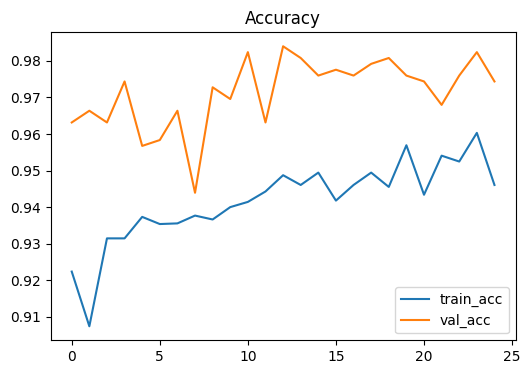

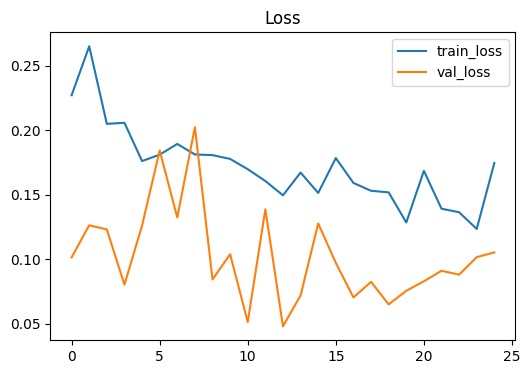

In [33]:
# --- Plot Accuracy ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

Test Accuracy: 0.8283 | Test Loss: 1.1499
Confusion Matrix:
 [[23  3  2  1  0  1  1  2]
 [ 0 15  0  0  0  0  0  5]
 [ 3  0 28  0  0  0  1  0]
 [ 0  0  4 27  0  1  1  0]
 [ 0  2  0  0 15  1  2  3]
 [ 1  1  0  0  0 22  1  0]
 [ 0  0  0  0  1  0 33  0]
 [ 0  1  0  0  2  0  0 30]]


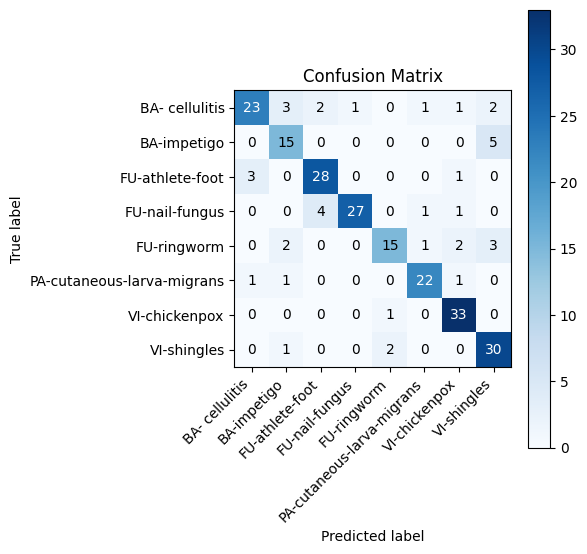

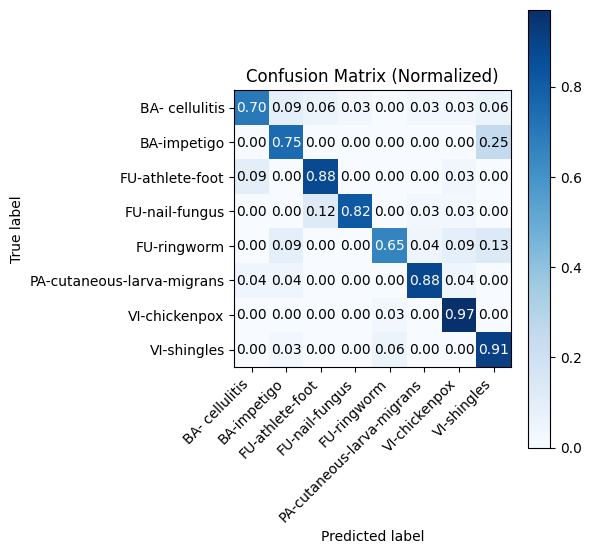


Classification Report:

                            precision    recall  f1-score   support

            BA- cellulitis       0.85      0.70      0.77        33
               BA-impetigo       0.68      0.75      0.71        20
           FU-athlete-foot       0.82      0.88      0.85        32
            FU-nail-fungus       0.96      0.82      0.89        33
               FU-ringworm       0.83      0.65      0.73        23
PA-cutaneous-larva-migrans       0.88      0.88      0.88        25
             VI-chickenpox       0.85      0.97      0.90        34
               VI-shingles       0.75      0.91      0.82        33

                  accuracy                           0.83       233
                 macro avg       0.83      0.82      0.82       233
              weighted avg       0.84      0.83      0.83       233



In [45]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np, itertools, matplotlib.pyplot as plt

# --- Evaluate on test set ---
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# --- Collect ground-truth labels ---
y_true = []
for xb, yb in test_ds:
    y_true.append(yb.numpy())
y_true = np.concatenate(y_true, axis=0).argmax(axis=1)

# --- Predictions ---
y_prob = model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

def plot_cm(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout(); plt.show()

# Plot both raw and normalized CM
plot_cm(cm, class_names, normalize=False, title="Confusion Matrix")
plot_cm(cm, class_names, normalize=True,  title="Confusion Matrix (Normalized)")

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [39]:
INPUT_SHAPE = IMG_SIZE + (3,)
# Pretrained backbone (ImageNet), exclude top
base = keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # freeze for initial training

# Build head
inputs = keras.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)  # scales to [-1, 1]
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs, name="mobilenetv2_transfer")

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
ckpt_path = "mobilenetv2_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True
    ),
]

EPOCHS = 25
history_m = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.5731 - loss: 1.2469 - val_accuracy: 0.9071 - val_loss: 0.3271
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9026 - loss: 0.3274 - val_accuracy: 0.9407 - val_loss: 0.1909
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9383 - loss: 0.2074 - val_accuracy: 0.9663 - val_loss: 0.1455
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9516 - loss: 0.1577 - val_accuracy: 0.9679 - val_loss: 0.1129
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9594 - loss: 0.1429 - val_accuracy: 0.9631 - val_loss: 0.1082
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9698 - loss: 0.1154 - val_accuracy: 0.9824 - val_loss: 0.0759
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9702 - loss: 0.1031 - val_accuracy: 0.9744 - val_loss: 0.0809
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.9708 - loss: 0.0971 - 

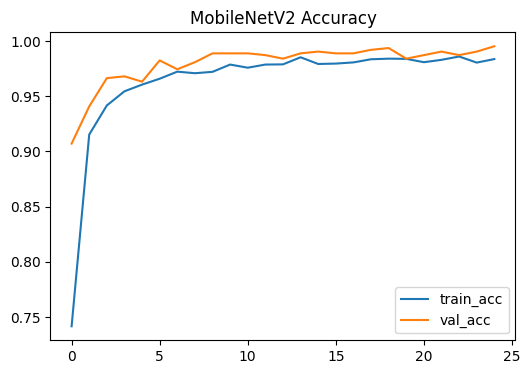

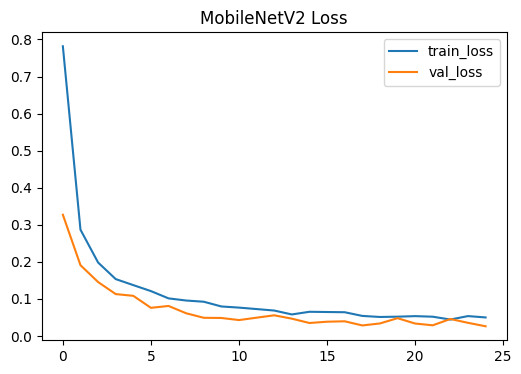

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history_m.history["accuracy"], label="train_acc")
plt.plot(history_m.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("MobileNetV2 Accuracy"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_m.history["loss"], label="train_loss")
plt.plot(history_m.history["val_loss"], label="val_loss")
plt.legend(); plt.title("MobileNetV2 Loss"); plt.show()

In [42]:
import numpy as np, itertools
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate
test_loss, test_acc = mobilenet_model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Collect ground-truth labels
y_true = []
for xb, yb in test_ds:
    y_true.append(yb.numpy())
y_true = np.concatenate(y_true, axis=0).argmax(axis=1)

# Predict
y_prob = mobilenet_model.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

import matplotlib.pyplot as plt

def plot_cm(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title); plt.colorbar()
    tick = np.arange(len(classes))
    plt.xticks(tick, classes, rotation=45, ha="right")
    plt.yticks(tick, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout(); plt.show()



Test Accuracy: 0.9700 | Test Loss: 0.1089
[[32  0  0  0  1  0  0  0]
 [ 0 20  0  0  0  0  0  0]
 [ 0  0 31  0  0  1  0  0]
 [ 0  0  0 33  0  0  0  0]
 [ 0  0  0  0 22  1  0  0]
 [ 1  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 34  0]
 [ 0  0  0  0  1  2  0 30]]


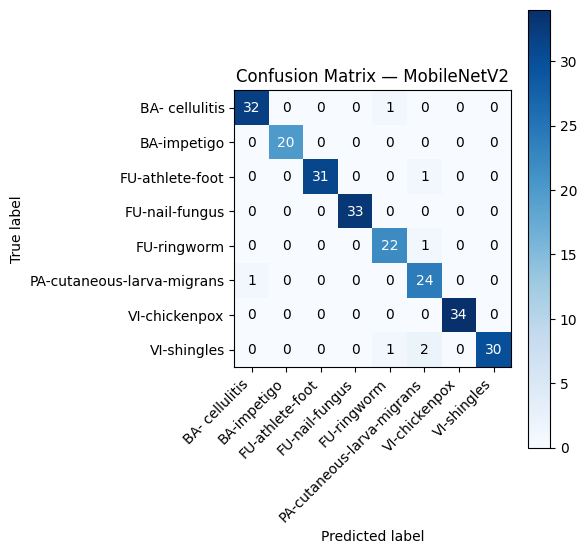

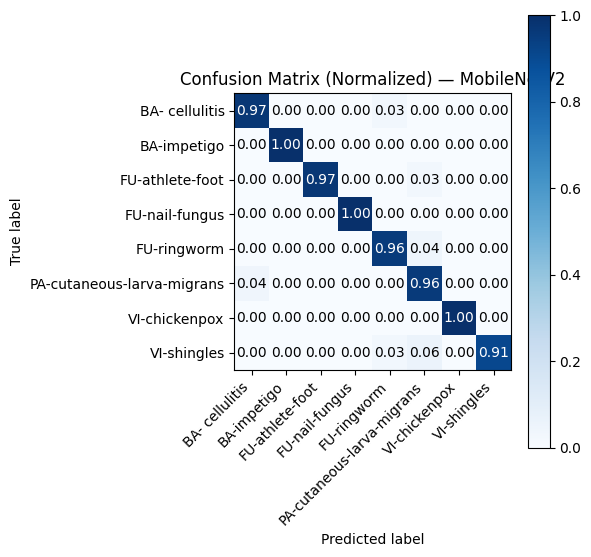

In [43]:
plot_cm(cm, class_names, normalize=False, title="Confusion Matrix — MobileNetV2")
plot_cm(cm, class_names, normalize=True,  title="Confusion Matrix (Normalized) — MobileNetV2")

In [44]:
print("\nClassification Report (MobileNetV2):\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (MobileNetV2):

                            precision    recall  f1-score   support

            BA- cellulitis       0.97      0.97      0.97        33
               BA-impetigo       1.00      1.00      1.00        20
           FU-athlete-foot       1.00      0.97      0.98        32
            FU-nail-fungus       1.00      1.00      1.00        33
               FU-ringworm       0.92      0.96      0.94        23
PA-cutaneous-larva-migrans       0.86      0.96      0.91        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       1.00      0.91      0.95        33

                  accuracy                           0.97       233
                 macro avg       0.97      0.97      0.97       233
              weighted avg       0.97      0.97      0.97       233

